In [40]:
import os
from random import random
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

root_path = 'data/transcriptions'
data_path = os.path.join(root_path,'train.csv')

In [41]:
class Vocab:
    def __init__(self, counter,for_encoder=False, min_freq=None):
        self.sos = "<sos>"
        self.eos = "<eos>"
        self.pad = "<pad>"
        self.unk = "<unk>"
        
        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3
        
        if for_encoder:
            self._token2idx = {
                self.pad:self.pad_idx,
                self.unk:self.unk_idx,
            }
        else:
            self._token2idx = {
                self.sos: self.sos_idx,
                self.eos: self.eos_idx,
                self.pad: self.pad_idx,
                self.unk: self.unk_idx,
            }
        self._idx2token = {idx:token for token, idx in self._token2idx.items()}
        
        
        idx = len(self._token2idx)
        min_freq = 0 if min_freq is None else min_freq
        
        for token, count in counter.items():
            if count > min_freq:
                self._token2idx[token] = idx
                self._idx2token[idx]   = token
                idx += 1
        
        self.vocab_size = len(self._token2idx)
        self.tokens     = list(self._token2idx.keys())
    
    def token2idx(self, token):
        return self._token2idx.get(token, self.pad_idx)
    
    def idx2token(self, idx):
        return self._idx2token.get(idx, self.pad)
    
    def sent2idx(self, sent):
        return [self.token2idx(i) for i in sent]
    
    def idx2sent(self, idx):
        return [self.idx2token(i) for i in idx]
    
    def __len__(self):
        return len(self._token2idx)
    
    def __repr__(self):
        
        return '{}'.format(self._token2idx)

In [526]:
class CharactersDataset(Dataset):
    
    def __init__(self,csv_file_path,transform = None):
        self.file = pd.read_csv(csv_file_path,'r')
        self.transform = transform
        self.data = []
        self.characters_vocab = None
        self.transcripts_vocab = None
        self.non_needed_symbols = '\'#$?\\_({)}-:\";!%.1234567890'
        
        self.make_dataset()
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        x = self.data[idx]['x']
        y = self.data[idx]['y']
        data = {'x':x,'y':y}
        if self.transform:
            data = self.transform(data)
    
        return data
    
    def make_dataset(self):
        characters = set()
        transcripts = set()
        for idx in range(len(self.file)):
            item = str(self.file.iloc[idx][0]).split(',')
            
            x = item[1].strip()
            for symbol in self.non_needed_symbols:
                x = x.replace(symbol,'')
            y = item[2].replace(' ','')
            self.data.append({'x':x,'y':y})
            for character in x:
                characters.add(character)
            for transcript in y:
                transcripts.add(transcript)
        
        self.characters_vocab = Vocab({v:k for k,v in dict(enumerate(characters,start=2)).items()},for_encoder=True)
        self.transcripts_vocab = Vocab({v:k for k,v in dict(enumerate(transcripts,start=4)).items()})
    
            
    def collate_fn(self, batch): 
        x_values = []
        y_values_in = []
        x_lengths = []
        y_lengths = []
        for item in batch:
            
            x_values.append([self.characters_vocab.token2idx(ch) for ch in item['x']])
            y_values_in.append([self.transcripts_vocab.token2idx(tr) for tr in item['y']])
        
        
        max_x = len(max(x_values,key=len))
        max_y = len(max(y_values_in,key=len))
        
        for word_index in range(len(x_values)):
            
            x_lengths.append(len(x_values[word_index]))
            y_lengths.append(len(y_values_in[word_index]))
            
            for _ in range(1+ max_x - len(x_values[word_index])):
                x_values[word_index].append(0)
            for _ in range(1+ max_y - len(y_values_in[word_index])):
                y_values_in[word_index].append(0)
            
            y_values_in[word_index].insert(0,2)
            
        x_values = torch.tensor(x_values)
        y_values_in_tensor = torch.tensor(y_values_in)
        
        y_values_out = y_values_in        
        for arr_index in range(len(y_values_out)):
            index_of_first_zero = y_values_out[arr_index].index(0)
            y_values_out[arr_index][index_of_first_zero] = 3
            y_values_out[arr_index] = y_values_out[arr_index][1:]+[0]
            
        y_values_out_tensor = torch.tensor(y_values_out)
        
        return x_values,y_values_in_tensor,y_values_out_tensor

In [527]:
dataset = CharactersDataset(data_path)
dataloader = DataLoader(dataset,batch_size=32,shuffle=True,num_workers=2,collate_fn = dataset.collate_fn)

In [203]:
for kek in dataloader:
    kek = kek
    break

In [554]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                           sampler=train_sampler,collate_fn = dataset.collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                                sampler=valid_sampler,collate_fn = dataset.collate_fn)

In [555]:
class EncoderLSTM(nn.Module):
    def __init__(self,embed_dim,hidden_size,output_size,n_layers = 1,dropout=0):
        super(EncoderLSTM,self).__init__()
        
        self.embedding = nn.Embedding(output_size,embed_dim,padding_idx = 0)
        self.LSTM = nn.LSTM(embed_dim,hidden_size,n_layers,dropout=(0 if n_layers == 1 else dropout),batch_first=True)
    
    def forward(self,input_seq,hidden=None):
        embedded = self.embedding(input_seq)
        #packed = nn.utils.rnn.pack_padded_sequence(embedded,input_lengths)
        outputs,hidden = self.LSTM(embedded)
        #outputs,_ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs,hidden

In [556]:
class DecoderLSTM(nn.Module):
    def __init__(self,embed_dim,hidden_size,output_size,n_layers=1,dropout=0):
        super(DecoderLSTM,self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        #layers
        self.embedding = nn.Embedding(output_size,embed_dim, padding_idx = 0)
        self.LSTM = nn.LSTM(embed_dim,hidden_size,n_layers,dropout = (0 if n_layers == 1 else self.dropout),batch_first=True)
        self.out = nn.Linear(hidden_size,output_size)
        
        
    def forward(self,input_step,last_hidden):
        #input_step (batch_size,seq_len)
        embedded = self.embedding(input_step)
        #embedded(batch_size,seq_len,hidden_dim)

        output,hidden = self.LSTM(embedded,last_hidden)
        #output(batch_size,seq_len,hidden_dim)
        #seq_len = 1 if we using teacher forcing
        #output = output.squeeze(1) #(batch_size,hidden_dim) for teacher forcing
        
        prediction = self.out(output)
        #prediction(seq_len,batch_size,output_dim) if no teacher_forcing
        
        return prediction,hidden

In [ ]:
hidden = encoder(kek[0].to(device))
output,hidden = decoder(kek[1].to(device),hidden)

In [ ]:
hidden.shape

In [557]:
encoder = EncoderLSTM(32,64,len(dataset.characters_vocab)).to(device)

In [558]:
decoder = DecoderLSTM(32,64,len(dataset.transcripts_vocab)).to(device)
len(dataset.characters_vocab)

28

In [559]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [560]:
import random
class seq2seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self,x,y,teacher_forcing_ratio = 0.3):
        
        encoder_output,hidden = self.encoder(x)
        decoder_outputs,hidden = self.decoder(y,hidden)
        
       
        #hidden = self.encoder(x)
        #input_token = y[:,0]
        
        #for t in range(1,seq_len):
         #   output,hidden = self.decoder(input_token,hidden)
          #  outputs[t] = output
           # teacher_force = random.random() < teacher_forcing_ratio
            #top1 = output.max(1)[1]
           # input_token = (y[:,t] if teacher_force else top1)
        
        return decoder_outputs
    
    def predict(self,x):
        
        #batch_size = 1!
        x.unsqueeze_(0)
        encoder_outputs,hidden = self.encoder(x)
        char_to_input = torch.LongTensor([[2]]).to(device)
        preds = []
        while True:
            predictions, hidden = self.decoder(char_to_input, hidden)
            index_of_next = torch.argmax(predictions)
            our_value = index_of_next.item()
            if our_value == 3:
                break
            preds.append(our_value)
            char_to_input = index_of_next.unsqueeze_(0).unsqueeze_(0)
        return preds

In [561]:
model = seq2seq(encoder,decoder,device).to(device)

In [377]:
output,hidden = encoder(x)
out_input = torch.LongTensor([[2]]).to(device)
preds = []

output,hidden = decoder(out_input,hidden)

In [389]:
output = torch.argmax(output)
output.unsqueeze_(0).unsqueeze_(0).shape

torch.Size([1, 1])

In [562]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

seq2seq(
  (encoder): EncoderLSTM(
    (embedding): Embedding(28, 32, padding_idx=0)
    (LSTM): LSTM(32, 64, batch_first=True)
  )
  (decoder): DecoderLSTM(
    (embedding): Embedding(28, 32, padding_idx=0)
    (LSTM): LSTM(32, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=28, bias=True)
  )
)

In [563]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 53,788 trainable parameters


In [564]:
optimizer = optim.Adam(model.parameters())

In [565]:
dataset.transcripts_vocab

{'<sos>': 2, '<eos>': 3, '<pad>': 0, '<unk>': 1, 'M': 4, 'J': 5, 'W': 6, 'D': 7, 'T': 8, 'H': 9, 'L': 10, 'C': 11, 'R': 12, 'S': 13, 'Y': 14, 'I': 15, 'Z': 16, 'K': 17, 'O': 18, 'F': 19, 'G': 20, 'P': 21, 'V': 22, 'U': 23, 'E': 24, 'A': 25, 'N': 26, 'B': 27}

In [566]:
criterion = nn.CrossEntropyLoss(ignore_index = 0)


In [567]:
def train(model, iterator, optimizer, criterion, clip,epoch,train_loss_list):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        x = batch[0].to(device)
        y_in = batch[1].to(device)
        y_out = batch[2].to(device)
        
        optimizer.zero_grad()
        
        output = model(x, y_in)
        #output dim (y_seq_len,batch_size,output_dim)
        output = output.view(output.shape[0]*output.shape[1],-1)
        y_out = y_out.view(-1)
        
        loss = criterion(output, y_out)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())

        if i % 500 == 0:
            plot(epoch, i, train_loss_list)
    return epoch_loss / len(iterator)

In [568]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            x = batch[0].to(device)
            y_in = batch[1].to(device)
            y_out = batch[2].to(device)
            
            output = model(x,y_in,0) #turn off teacher forcing
            
            output = output.view(output.shape[0]*output.shape[1],-1)
            y_out = y_out.view(-1)

            loss = criterion(output, y_out)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)



In [569]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot(epoch, step, train_losses):
    clear_output(True)
    plt.title(f'Epochs {epoch}, step {step}')
    plt.plot(train_losses)
    plt.show()

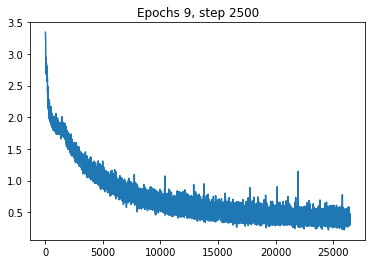

	Train Loss: 0.391 | Train PPL:   1.479


In [570]:
import math

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_losses = []
for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP,epoch,train_losses)
    valid_loss = evaluate(model, validation_loader, criterion)
    
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

In [571]:
torch.save(encoder.state_dict(),'encoder_weights')
torch.save(decoder.state_dict(),'decoder_weights')
torch.save(model.state_dict(),'model_weights')

In [479]:
encoder.load_state_dict(torch.load('encoder_weights'))
decoder.load_state_dict(torch.load('decoder_weights'))
model = seq2seq(encoder,decoder,device)
model.load_state_dict(torch.load('model_weights'))

In [572]:
def predict_batch(model,batch,batch_size):
    x_tokens = []
    y_tokens_predicted = []
    y_tokens_true = []
    for i in range(batch_size):
        x_tokens.append(''.join([dataset.characters_vocab.idx2token(k.item()) for k in batch[0][i] if k.item() != 0]))
        y_pred = model.predict(batch[0][i].to(device))
        y_tokens_predicted.append(''.join([dataset.transcripts_vocab.idx2token(k) for k in y_pred]))
        y_tokens_true.append(''.join([dataset.transcripts_vocab.idx2token(k.item()) for k in batch[1][i] if k.item() != 0 and k.item() != 2]))
    for i in range(len(x_tokens)):
        print('Input:',x_tokens[i])
        print('Predicted_output:',y_tokens_predicted[i])
        print('True output:',y_tokens_true[i],'\n\n')

In [575]:
predict_batch(model,kek,32)

Input: CATAWBA
Predicted_output: KAETAHBAO
True output: KAHTAOBAH 


Input: VERIFY
Predicted_output: VERIHFIY
True output: VEHRAHFAY 


Input: MANEUVERINGS
Predicted_output: MAHNIHVAHNBIHNZ
True output: MAHNUWVERIHNGZ 


Input: FALLIS
Predicted_output: FAELIHS
True output: FAELIHS 


Input: OLEOYL
Predicted_output: OWLIYAHL
True output: OWLIYOYL 


Input: BLAMES
Predicted_output: BLEYMZ
True output: BLEYMZ 


Input: HOODLUMS
Predicted_output: HHUWDLAHMZ
True output: HHUWDLAHMZ 


Input: BOXES
Predicted_output: BAAKSIHZ
True output: BAAKSIHZ 


Input: FELLHEIMER
Predicted_output: FEHLHHIYLERD
True output: FEHLHHAYMER 


Input: GLOATS
Predicted_output: GLOWTS
True output: GLOWTS 


Input: ACHILLES
Predicted_output: AECHAHLZ
True output: AHKIHLIYZ 


Input: CUMINGS
Predicted_output: KUWMIHNGZ
True output: KUWMIHNGZ 


Input: SHAPERO
Predicted_output: SHEYPEHROW
True output: SHAHPIHROW 


Input: SHEAF
Predicted_output: SHIYF
True output: SHIYF 


Input: SHAY
Predicted_output: SHIY
True out

In [574]:
inp = ''
out = ''
for i in x: 
    inp += dataset.characters_vocab.idx2token(i.item())
for i in y:
    out += dataset.transcripts_vocab.idx2token(i.item())
inp,out

('CATAWBA<pad><pad><pad><pad><pad><pad><pad>',
 '<sos>KAHTAOBAH<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>')

In [476]:
kek[0][1]

torch.Size([18])

In [460]:
x_tokens

NameError: name 'x_tokens' is not defined